In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from cancer_pattern_mining import (
    SequenceTransformer, 
    SequencePatternMiner,
    analyze_sequences
)


#### Load Dataset

In [ ]:
df = pd.read_csv('../RawData/cancer_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDiagnosis distribution:")
print(df['diagnosis'].value_counts())
df.head()

Dataset shape: (569, 33)

Diagnosis distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
# Transform to sequences
top_k = 5
transformer = SequenceTransformer(top_k=5, max_length=3, max_gap=1)  # k = 5 represents ~17% of features; L=3 allows 2-feature and 3-feature interactions while considering longer sequences have lower support as they are rarer
sequences = transformer.fit_transform(df)
print(f"Created {len(sequences)} patient records with subsequences")

# Calculate total subsequences generated
total_subsequences = sum(len(seq['subsequences']) for seq in sequences)
print(f"Total subsequences generated: {total_subsequences}")
print(f"Average subsequences per patient: {total_subsequences/len(sequences):.0f}")

# Show example sequences
print("Example Patient Records:")

for i, seq in enumerate(sequences[:3]):  # Show first 3 patients
    print(f"Patient {seq['id']} (Diagnosis: {seq['diagnosis']})")
    
    # Show top-k features with z-scores
    print(f"\nTop-{top_k} Most Abnormal Features (by absolute z-score):")
    for rank, (feature, zscore) in enumerate(zip(seq['top_features'], seq['z_scores']), 1):
        print(f"{rank}. {feature:30s} (abs(z-score): {zscore:6.4f})")
    
    # Show generated subsequences by length
    subsequences = seq['subsequences']
    
    # Group by length
    by_length = {}
    for subseq in subsequences:
        length = len(subseq)
        if length not in by_length:
            by_length[length] = []
        by_length[length].append(subseq)
    
    print(f"\nGenerated Subsequences for patient:")
    for length in sorted(by_length.keys()):
        subseqs = by_length[length]
        print(f"Length {length}: {len(subseqs)} subsequences, 3 examples:")
        # Show first 3 examples for each length
        for subseq in subseqs[:3]:
            subseq_str = ' → '.join([f'"{feature}"' for feature in subseq])
            print(f"{subseq_str}")
        print() 

# Summary statistics
print("Summary Statistics:")

# Count subsequences by length across all patients
length_counts = {1: 0, 2: 0, 3: 0}
for seq in sequences:
    for subseq in seq['subsequences']:
        length = len(subseq)
        if length in length_counts:
            length_counts[length] += 1

print(f"Subsequence distribution across {len(sequences)} patients:")
for length, count in sorted(length_counts.items()):
    print(f"Length {length}: {count:6d} subsequences ({count/total_subsequences*100:.1f}%)")

# Check diagnosis distribution
diagnosis_counts = {}
for seq in sequences:
    diag = seq['diagnosis']
    diagnosis_counts[diag] = diagnosis_counts.get(diag, 0) + 1

print(f"\nDiagnosis distribution:")
for diag, count in sorted(diagnosis_counts.items()):
    print(f"{diag}: {count:4d} patients ({count/len(sequences)*100:.1f}%)")

Created 569 patient records with subsequences
Total subsequences generated: 11380
Average subsequences per patient: 20
Example Patient Records:
Patient 842302 (Diagnosis: M)

Top-5 Most Abnormal Features (by absolute z-score):
1. compactness_mean               (abs(z-score): 3.2835)
2. perimeter_se                   (abs(z-score): 2.8330)
3. symmetry_worst                 (abs(z-score): 2.7506)
4. concavity_mean                 (abs(z-score): 2.6529)
5. compactness_worst              (abs(z-score): 2.6167)

Generated Subsequences for patient:
Length 1: 5 subsequences, 3 examples:
"compactness_mean"
"perimeter_se"
"symmetry_worst"

Length 2: 7 subsequences, 3 examples:
"compactness_mean" → "perimeter_se"
"compactness_mean" → "symmetry_worst"
"perimeter_se" → "symmetry_worst"

Length 3: 8 subsequences, 3 examples:
"compactness_mean" → "perimeter_se" → "symmetry_worst"
"compactness_mean" → "perimeter_se" → "concavity_mean"
"compactness_mean" → "symmetry_worst" → "concavity_mean"

Patient 

In [ ]:
# Analyze sequence statistics
def analyze_sequences(sequences):
    """Analyze statistics from the new sequence structure"""
    stats = {}
    
    # Diagnosis counts
    malignant_count = sum(1 for s in sequences if s['diagnosis'] == 'M')
    benign_count = sum(1 for s in sequences if s['diagnosis'] == 'B')
    stats['malignant_count'] = malignant_count
    stats['benign_count'] = benign_count
    stats['total_patients'] = len(sequences)
    
    # Subsequence statistics
    all_subsequences = []
    subsequence_counts_per_patient = []
    
    for seq in sequences:
        subsequences = seq['subsequences']
        all_subsequences.extend(subsequences)
        subsequence_counts_per_patient.append(len(subsequences))
    
    stats['total_subsequences'] = len(all_subsequences)
    
    # Subsequence length distribution
    subsequence_lengths = [len(subseq) for subseq in all_subsequences]
    stats['avg_subsequence_length'] = np.mean(subsequence_lengths)
    stats['length_1_count'] = sum(1 for l in subsequence_lengths if l == 1)
    stats['length_2_count'] = sum(1 for l in subsequence_lengths if l == 2)
    stats['length_3_count'] = sum(1 for l in subsequence_lengths if l == 3)
    
    # Feature frequency in subsequences
    feature_counts = {}
    for subseq in all_subsequences:
        for feature in subseq:
            feature_counts[feature] = feature_counts.get(feature, 0) + 1
    
    stats['unique_features_in_subsequences'] = len(feature_counts)
    stats['most_common_feature'] = max(feature_counts.items(), key=lambda x: x[1])
    
    return stats, subsequence_counts_per_patient, subsequence_lengths, feature_counts

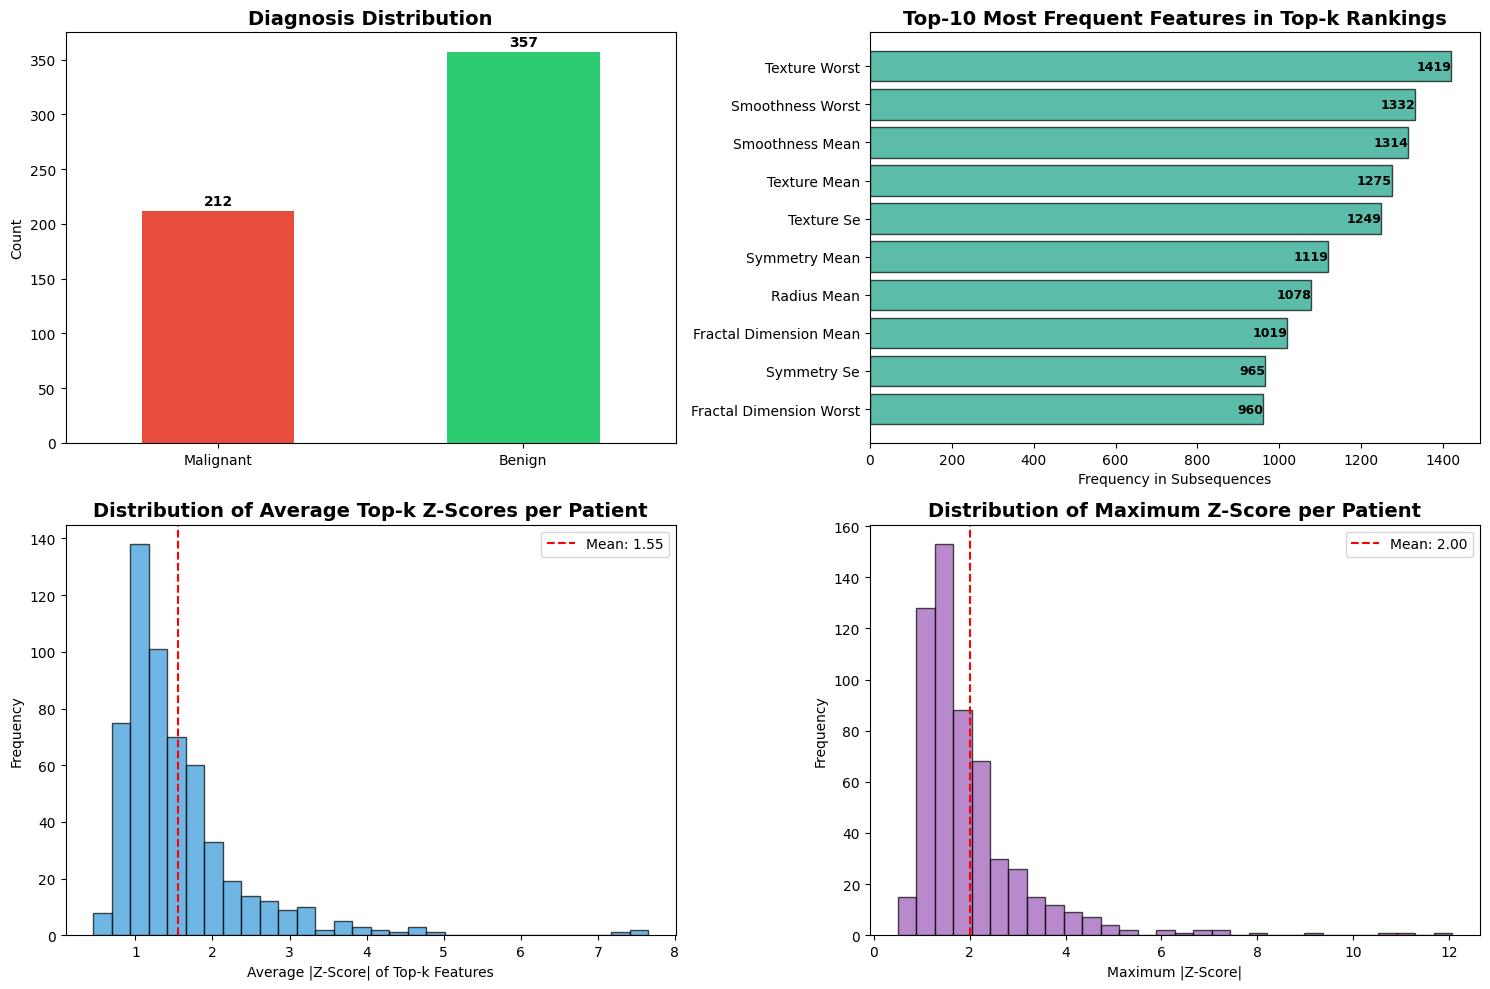

SEQUENCE MINING STATISTICS

                          PATIENT STATISTICS                          
----------------------------------------------------------------------
Total patients                                  569
Malignant (M)                                   212 (37.3%)
Benign (B)                                      357 (62.7%)

                        SUBSEQUENCE GENERATION                        
----------------------------------------------------------------------
Subsequences per patient (constant)              20
  - Length 1                                      5
  - Length 2                                      7
  - Length 3                                      8
Total subsequences (569 patients × 20)        11380

                          Z-SCORE STATISTICS                          
----------------------------------------------------------------------
Average of patient average z-scores            1.55
Average of patient max z-scores                2.00
Overall 

In [ ]:
stats, subseq_counts, subseq_lengths, feature_counts = analyze_sequences(sequences)

# Create more meaningful visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Diagnosis distribution
diagnosis_counts = pd.Series({
    'Malignant': stats['malignant_count'],
    'Benign': stats['benign_count']
})
diagnosis_counts.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#2ecc71'])
axes[0, 0].set_title('Diagnosis Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['Malignant', 'Benign'], rotation=0)
for i, v in enumerate(diagnosis_counts):
    axes[0, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 2. Top-10 most frequent features in top-k rankings
top_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_feature_names = [f[0].replace('_', ' ').title()[:25] for f in top_features]
top_feature_counts = [f[1] for f in top_features]

axes[0, 1].barh(range(len(top_feature_names)), top_feature_counts, 
                color='#16a085', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_feature_names)))
axes[0, 1].set_yticklabels(top_feature_names, fontsize=10)
axes[0, 1].set_xlabel('Frequency in Subsequences')
axes[0, 1].set_title('Top-10 Most Frequent Features in Top-k Rankings', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
for i, count in enumerate(top_feature_counts):
    axes[0, 1].text(count, i, str(count), va='center', ha='right', fontweight='bold', fontsize=9)

# 3. Distribution of average z-scores across patients
avg_z_scores = [np.mean(seq['z_scores']) for seq in sequences]
axes[1, 0].hist(avg_z_scores, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Average Top-k Z-Scores per Patient', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average |Z-Score| of Top-k Features')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.mean(avg_z_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(avg_z_scores):.2f}')
axes[1, 0].legend()

# 4. Distribution of max z-scores across patients 
max_z_scores = [max(seq['z_scores']) for seq in sequences]
axes[1, 1].hist(max_z_scores, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Maximum Z-Score per Patient', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Maximum |Z-Score|')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.mean(max_z_scores), color='red', linestyle='--',
                   label=f'Mean: {np.mean(max_z_scores):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print("SEQUENCE MINING STATISTICS")


print(f"\n{'PATIENT STATISTICS':^70}")
print("-"*70)
print(f"{'Total patients':<40} {stats['total_patients']:>10}")
print(f"{'Malignant (M)':<40} {stats['malignant_count']:>10} ({stats['malignant_count']/stats['total_patients']*100:.1f}%)")
print(f"{'Benign (B)':<40} {stats['benign_count']:>10} ({stats['benign_count']/stats['total_patients']*100:.1f}%)")

print(f"\n{'SUBSEQUENCE GENERATION':^70}")
print("-"*70)
print(f"{'Subsequences per patient (constant)':<40} {20:>10}")
print(f"{'  - Length 1':<40} {5:>10}")
print(f"{'  - Length 2':<40} {7:>10}")
print(f"{'  - Length 3':<40} {8:>10}")
print(f"{'Total subsequences (569 patients × 20)':<40} {stats['total_subsequences']:>10}")

print(f"\n{'Z-SCORE STATISTICS':^70}")
print("-"*70)
print(f"{'Average of patient average z-scores':<40} {np.mean(avg_z_scores):>10.2f}")
print(f"{'Average of patient max z-scores':<40} {np.mean(max_z_scores):>10.2f}")
print(f"{'Overall max z-score observed':<40} {max(max_z_scores):>10.2f}")

print(f"\n{'FEATURE STATISTICS':^70}")
print("-"*70)
print(f"{'Number of unique features appearing in top-k':<40} {stats['unique_features_in_subsequences']:>10}")
print(f"Most frequent feature in top-k is {stats['most_common_feature'][0]}.")
print(f"It appears in {stats['most_common_feature'][1]} subsequences.")

print("\n" + "="*70)

In [ ]:
malignant_avg_z = [np.mean(seq['z_scores']) for seq in sequences if seq['diagnosis'] == 'M']
benign_avg_z = [np.mean(seq['z_scores']) for seq in sequences if seq['diagnosis'] == 'B']

# Hypothesis: Malignant will have higher avg z-scores
print(f"Malignant average z-score: {np.mean(malignant_avg_z):.2f}")
print(f"Benign average z-score: {np.mean(benign_avg_z):.2f}")

Malignant average z-score: 1.93
Benign average z-score: 1.33


### As we would expect, malignant cases have greater higher average z-scores in top-5 sequences.

In [ ]:
# Mine patterns with different support thresholds?

miner = SequencePatternMiner(min_support=0.05, max_pattern_length=3)
patterns = miner.mine_patterns(sequences)

print(f"Found {len(patterns)} frequent patterns")

if len(patterns) > 0:
    print(f"Malignant-discriminative: {len(patterns[patterns['discriminates'] == 'Malignant'])}")
    print(f"Benign-discriminative: {len(patterns[patterns['discriminates'] == 'Benign'])}")
    print(f"Neutral: {len(patterns[patterns['discriminates'] == 'Neutral'])}")
else:
    print("No patterns found. Try lowering min_support")

Processing 212 malignant and 357 benign patient records
Found 1917 unique patterns in malignant, 2634 in benign
Successfully mined 50 patterns meeting support threshold
Found 50 frequent patterns
Malignant-discriminative: 20
Benign-discriminative: 20
Neutral: 10


In [ ]:
# Display top patterns
print("\n" + "=" * 100)
print("TOP 20 DISCRIMINATIVE PATTERNS")
print("=" * 100)

if len(patterns) > 0:
    top_patterns = patterns.head(20)
    display_df = top_patterns[['pattern_str', 'length', 'malignant_support', 
                               'benign_support', 'lift', 'discriminates']].copy()
    display_df.columns = ['Pattern', 'Len', 'M_Supp', 'B_Supp', 'Lift', 'Discriminates']
    display_df['M_Supp'] = display_df['M_Supp'].round(3)
    display_df['B_Supp'] = display_df['B_Supp'].round(3)
    display_df['Lift'] = display_df['Lift'].round(3)
    display(display_df)
else:
    print("No patterns to display. Lower the min_support threshold.")


TOP 20 DISCRIMINATIVE PATTERNS


,Pattern,Len,M_Supp,B_Supp,Lift,Discriminates
0,{area_se},1,0.104,0.000,45.000,Malignant
1,{area_mean} → {perimeter_mean},2,0.085,0.000,37.000,Malignant
2,{area_worst},1,0.179,0.003,35.197,Malignant
3,{area_worst} → {radius_worst},2,0.075,0.000,33.000,Malignant
4,{radius_mean} → {area_mean},2,0.071,0.000,31.000,Malignant
5,{area_worst} → {radius_mean},2,0.057,0.000,25.000,Malignant
6,{concave points_se} → {concave points_worst},2,0.000,0.056,0.040,Benign
7,{symmetry_mean} → {smoothness_worst},2,0.000,0.053,0.042,Benign
8,{area_worst} → {perimeter_worst},2,0.052,0.000,23.000,Malignant
9,{area_mean} → {radius_mean},2,0.090,0.003,17.827,Malignant


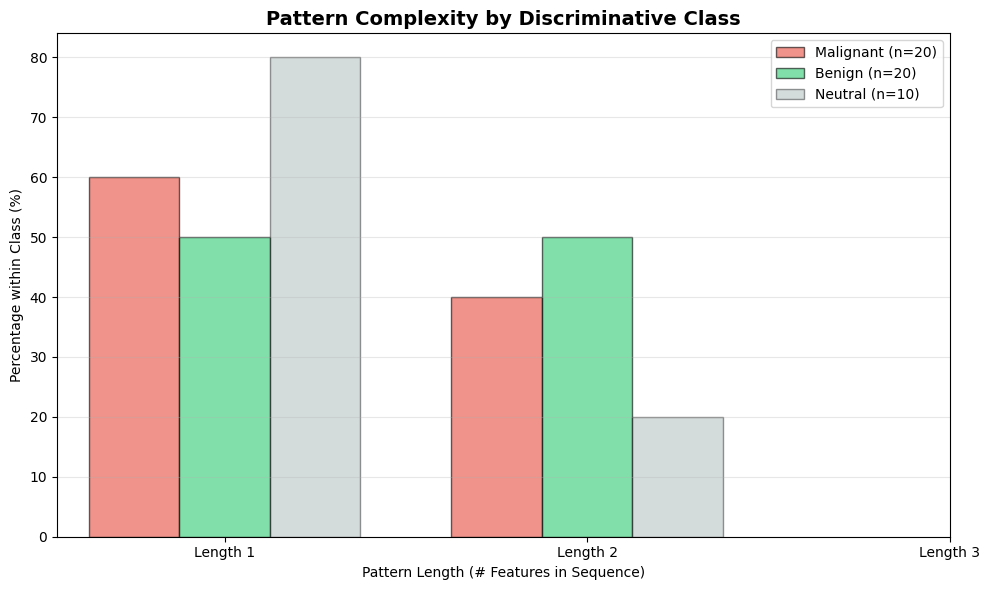


PATTERN LENGTH SUMMARY

Malignant Patterns (n=20):
  Length 1:  60.0% (12 patterns)
  Length 2:  40.0% (8 patterns)
  Mean length: 1.40

Benign Patterns (n=20):
  Length 1:  50.0% (10 patterns)
  Length 2:  50.0% (10 patterns)
  Mean length: 1.50

Neutral Patterns (n=10):
  Length 1:  80.0% (8 patterns)
  Length 2:  20.0% (2 patterns)
  Mean length: 1.20


In [ ]:
if len(patterns) == 0:
    print("No patterns found. Skipping visualizations.")
    print("Try lowering min_support")
else:
    # Visualization: Pattern length distribution by discriminative class
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pattern length distribution by class
    for disc_class, color, alpha in [('Malignant', '#e74c3c', 0.6), 
                                       ('Benign', '#2ecc71', 0.6), 
                                       ('Neutral', '#95a5a6', 0.4)]:
        subset = patterns[patterns['discriminates'] == disc_class]
        
        # Plot as percentage within each class
        if len(subset) > 0:
            length_counts = subset['length'].value_counts(normalize=True).sort_index()
            offset = 0.25 * (['Malignant', 'Benign', 'Neutral'].index(disc_class) - 1)
            ax.bar(length_counts.index + offset,
                   length_counts.values * 100,
                   width=0.25,
                   label=f'{disc_class} (n={len(subset)})',
                   color=color,
                   alpha=alpha,
                   edgecolor='black')
    
    ax.set_title('Pattern Complexity by Discriminative Class', fontsize=14, fontweight='bold')
    ax.set_xlabel('Pattern Length (# Features in Sequence)')
    ax.set_ylabel('Percentage within Class (%)')
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Length 1', 'Length 2', 'Length 3'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    

    
    # Print summary statistics
    print("\n" + "="*70)
    print("PATTERN LENGTH SUMMARY")
    print("="*70)
    for disc_class in ['Malignant', 'Benign', 'Neutral']:
        subset = patterns[patterns['discriminates'] == disc_class]
        if len(subset) > 0:
            print(f"\n{disc_class} Patterns (n={len(subset)}):")
            length_dist = subset['length'].value_counts(normalize=True).sort_index() * 100
            for length, pct in length_dist.items():
                count = int(pct * len(subset) / 100)
                print(f"  Length {length}: {pct:5.1f}% ({count} patterns)")
            print(f"  Mean length: {subset['length'].mean():.2f}")

In [ ]:
# Print the actual patterns with interpretable information
print("TOP 10 MALIGNANT-DISCRIMINATIVE PATTERNS")

top_malignant = patterns[patterns['discriminates'] == 'Malignant'].nlargest(10, 'lift')
for idx, (i, row) in enumerate(top_malignant.iterrows(), 1):
    print(f"\n{idx}. {row['pattern_str']}")
    print(f"   Lift: {row['lift']:.2f} | Length: {row['length']}")
    print(f"   Malignant: {row['malignant_support']:.1%} ({row['malignant_count']} patients)")
    print(f"   Benign:    {row['benign_support']:.1%} ({row['benign_count']} patients)")

print("TOP 10 BENIGN-DISCRIMINATIVE PATTERNS")

top_benign = patterns[patterns['discriminates'] == 'Benign'].nsmallest(10, 'lift')
for idx, (i, row) in enumerate(top_benign.iterrows(), 1):
    print(f"\n{idx}. {row['pattern_str']}")
    print(f"   Lift: {row['lift']:.2f} | Length: {row['length']}")
    print(f"   Malignant: {row['malignant_support']:.1%} ({row['malignant_count']} patients)")
    print(f"   Benign:    {row['benign_support']:.1%} ({row['benign_count']} patients)")

TOP 10 MALIGNANT-DISCRIMINATIVE PATTERNS

1. {area_se}
   Lift: 45.00 | Length: 1
   Malignant: 10.4% (22 patients)
   Benign:    0.0% (0 patients)

2. {area_mean} → {perimeter_mean}
   Lift: 37.00 | Length: 2
   Malignant: 8.5% (18 patients)
   Benign:    0.0% (0 patients)

3. {area_worst}
   Lift: 35.20 | Length: 1
   Malignant: 17.9% (38 patients)
   Benign:    0.3% (1 patients)

4. {area_worst} → {radius_worst}
   Lift: 33.00 | Length: 2
   Malignant: 7.5% (16 patients)
   Benign:    0.0% (0 patients)

5. {radius_mean} → {area_mean}
   Lift: 31.00 | Length: 2
   Malignant: 7.1% (15 patients)
   Benign:    0.0% (0 patients)

6. {area_worst} → {radius_mean}
   Lift: 25.00 | Length: 2
   Malignant: 5.7% (12 patients)
   Benign:    0.0% (0 patients)

7. {area_worst} → {perimeter_worst}
   Lift: 23.00 | Length: 2
   Malignant: 5.2% (11 patients)
   Benign:    0.0% (0 patients)

8. {area_mean} → {radius_mean}
   Lift: 17.83 | Length: 2
   Malignant: 9.0% (19 patients)
   Benign:    0.3% 

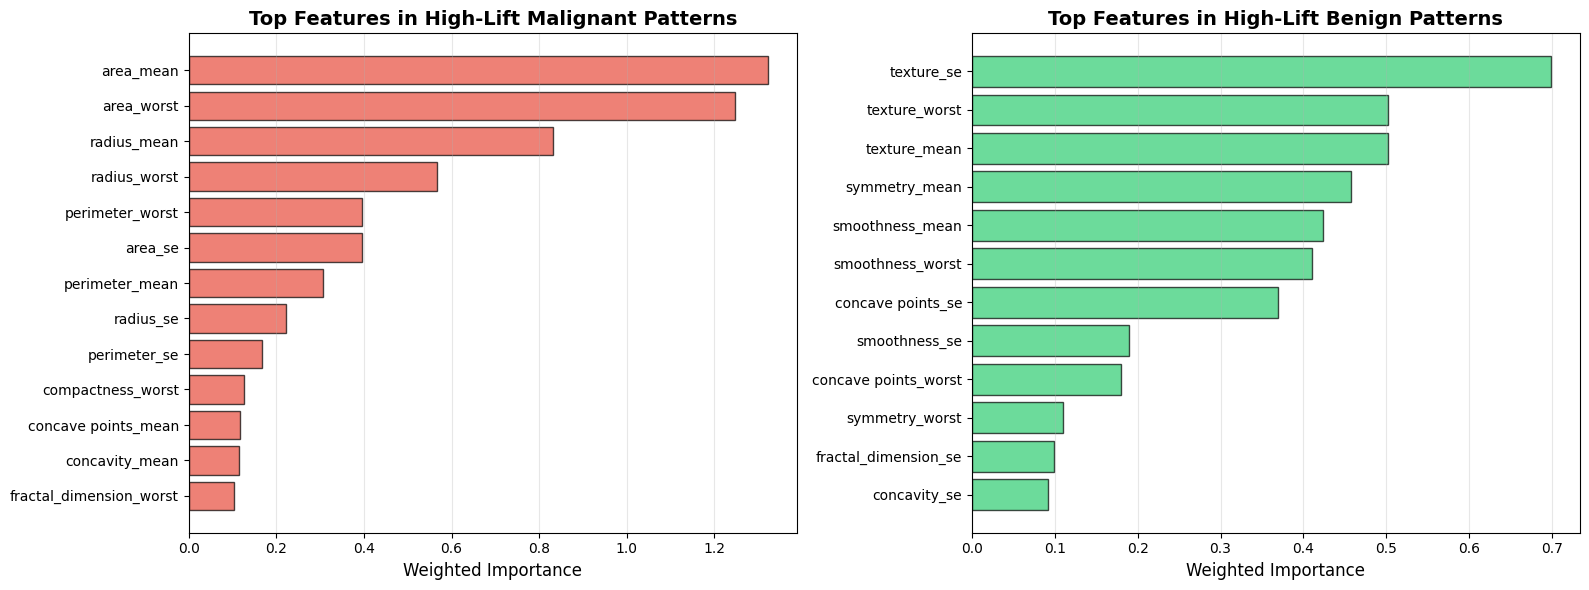

In [ ]:
# Better feature extraction with lift weighting
def extract_weighted_features(patterns_df, discriminates=None, top_n=20):
    if discriminates:
        # Get top patterns by lift for this class
        if discriminates == 'Malignant':
            patterns_df = patterns_df[patterns_df['discriminates'] == discriminates].nlargest(top_n, 'lift')
        else:  # Benign - want smallest lift values
            patterns_df = patterns_df[patterns_df['discriminates'] == discriminates].nsmallest(top_n, 'lift')
    
    feature_weights = defaultdict(float)
    
    for _, row in patterns_df.iterrows():
        pattern = row['pattern']
        lift = row['lift']
        support = row['malignant_support'] if discriminates == 'Malignant' else row['benign_support']
        
        # Weight each feature by pattern's lift × support (importance × prevalence)
        weight = abs(np.log(lift)) * support  # Use log(lift) for better scaling
        for feature in pattern:
            feature_weights[feature] += weight
    
    return feature_weights

# Get weighted feature importance
malignant_features = extract_weighted_features(patterns, 'Malignant', top_n=30)
benign_features = extract_weighted_features(patterns, 'Benign', top_n=30)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Malignant features
top_m = sorted(malignant_features.items(), key=lambda x: x[1], reverse=True)[:15]
if top_m:
    features_m, weights_m = zip(*top_m)
    axes[0].barh(features_m, weights_m, color='#e74c3c', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Weighted Importance', fontsize=12) # (|log(Lift)| × Support)
    axes[0].set_title('Top Features in High-Lift Malignant Patterns', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')

# Benign features
top_b = sorted(benign_features.items(), key=lambda x: x[1], reverse=True)[:15]
if top_b:
    features_b, weights_b = zip(*top_b)
    axes[1].barh(features_b, weights_b, color='#2ecc71', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Weighted Importance', fontsize=12) # (|log(Lift)| × Support) as for lift<1, abs(log(lift)) will be greater for smaller values of lift 
    axes[1].set_title('Top Features in High-Lift Benign Patterns', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


Pattern Analysis by Length:
                     pattern    lift         malignant_support benign_support
                       count    mean     std              mean           mean
length discriminates                                                         
1      Benign             10   0.475   0.110             0.128          0.259
       Malignant          12   9.113  14.811             0.196          0.079
       Neutral             8   0.952   0.230             0.170          0.183
2      Benign             10   0.260   0.187             0.017          0.068
       Malignant           8  21.432  13.240             0.071          0.007
       Neutral             2   1.049   0.533             0.104          0.101


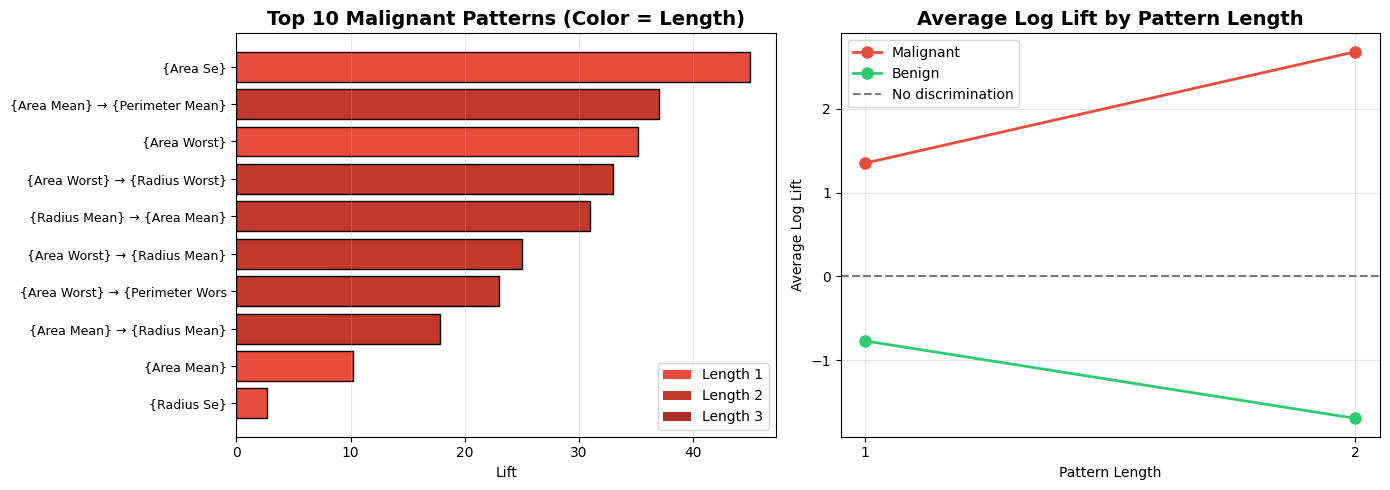

In [ ]:
if len(patterns) > 0:
    # Create log-transformed lift for visualization
    patterns_vis = patterns.copy()
    patterns_vis['log_lift'] = np.log(patterns_vis['lift'].clip(lower=0.01))
    
    # Analyze patterns by length
    length_analysis = patterns.groupby(['length', 'discriminates']).agg({
        'pattern': 'count',
        'lift': ['mean', 'std'],
        'malignant_support': 'mean',
        'benign_support': 'mean'
    }).round(3)
    
    print("\nPattern Analysis by Length:")
    print("=" * 80)
    print(length_analysis)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))


    # Chart 1: Show actual top patterns
    top_malignant = patterns[patterns['discriminates'] == 'Malignant'].nlargest(10, 'lift')
    pattern_names = [p.replace('_', ' ').title()[:30] for p in top_malignant['pattern_str']]
    colors = ['#e74c3c' if l == 1 else '#c0392b' if l == 2 else '#a93226' 
            for l in top_malignant['length']]

    axes[0].barh(range(len(pattern_names)), top_malignant['lift'], color=colors, edgecolor='black')
    axes[0].set_yticks(range(len(pattern_names)))
    axes[0].set_yticklabels(pattern_names, fontsize=9)
    axes[0].set_xlabel('Lift')
    axes[0].set_title('Top 10 Malignant Patterns (Color = Length)', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')

    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#e74c3c', label='Length 1'),
                    Patch(facecolor='#c0392b', label='Length 2'),
                    Patch(facecolor='#a93226', label='Length 3')]
    axes[0].legend(handles=legend_elements)

    # Chart 2: Use log lift
    for disc_class, color in [('Malignant', '#e74c3c'), ('Benign', '#2ecc71')]:
        subset = patterns_vis[patterns_vis['discriminates'] == disc_class]
        avg_log_lift = subset.groupby('length')['log_lift'].mean()
        axes[1].plot(avg_log_lift.index, avg_log_lift.values, marker='o', 
                    label=disc_class, color=color, linewidth=2, markersize=8)
    axes[1].set_ylabel('Average Log Lift')
    axes[1].set_title('Average Log Lift by Pattern Length', fontsize=14, fontweight='bold')
    
    # Add reference line at log(1) = 0 (no discrimination)
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No discrimination')

    axes[1].set_xlabel('Pattern Length')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_xticks(range(1, patterns['length'].max() + 1))

    plt.tight_layout()
    plt.show()

In [ ]:
# Export to CSV
from cancer_pattern_mining import export_results

export_results(patterns, sequences, output_prefix='cancer_mining_results')
print("\nResults exported successfully!")
print("Files created:")
print("  - cancer_mining_results_patterns.csv")
print("  - cancer_mining_results_sequences.csv")

Exported 50 patterns to cancer_mining_results_patterns.csv
Exported 569 patient records to cancer_mining_results_patient_features.csv
Files created:
  1. cancer_mining_results_patterns.csv - 50 mined patterns
  2. cancer_mining_results_patient_features.csv - 569 patient records

Results exported successfully!
Files created:
  - cancer_mining_results_patterns.csv
  - cancer_mining_results_sequences.csv


In [ ]:
print("KEY FINDINGS SUMMARY:")

# Top malignant pattern
top_m = patterns[patterns['discriminates'] == 'Malignant'].nlargest(1, 'lift').iloc[0]
print(f"\n1. STRONGEST MALIGNANT PATTERN:")
print(f"   Pattern: {top_m['pattern_str']}")
print(f"   Lift: {top_m['lift']:.2f}")
print(f"   Malignant Support: {top_m['malignant_support']:.2%} ({top_m['malignant_count']} patients)")
print(f"   Benign Support: {top_m['benign_support']:.2%} ({top_m['benign_count']} patients)")

# Top benign pattern
top_b = patterns[patterns['discriminates'] == 'Benign'].nsmallest(1, 'lift').iloc[0]
print(f"\n2. STRONGEST BENIGN PATTERN:")
print(f"   Pattern: {top_b['pattern_str']}")
print(f"   Lift: {top_b['lift']:.2f}")
print(f"   Malignant Support: {top_b['malignant_support']:.2%} ({top_b['malignant_count']} patients)")
print(f"   Benign Support: {top_b['benign_support']:.2%} ({top_b['benign_count']} patients)")

# Most common features
malignant_features = Counter()
for pattern in patterns[patterns['discriminates'] == 'Malignant'].nlargest(20, 'lift')['pattern']:
    malignant_features.update(pattern)

benign_features = Counter()
for pattern in patterns[patterns['discriminates'] == 'Benign'].nsmallest(20, 'lift')['pattern']:
    benign_features.update(pattern)

print(f"\n3. MOST DISCRIMINATIVE FEATURES:")
print(f"   Malignant: {', '.join([f for f, _ in malignant_features.most_common(5)])}")
print(f"   Benign: {', '.join([f for f, _ in benign_features.most_common(5)])}")

# Pattern statistics
print(f"\n4. PATTERN STATISTICS:")
print(f"   Total patterns found: {len(patterns)}")
print(f"   Malignant-discriminative: {len(patterns[patterns['discriminates'] == 'Malignant'])}")
print(f"   Benign-discriminative: {len(patterns[patterns['discriminates'] == 'Benign'])}")
print(f"   Neutral patterns: {len(patterns[patterns['discriminates'] == 'Neutral'])}")
print(f"   Average pattern length: {patterns['length'].mean():.2f}")
print(f"   Most common length: {patterns['length'].mode()[0]}")



KEY FINDINGS SUMMARY:

1. STRONGEST MALIGNANT PATTERN:
   Pattern: {area_se}
   Lift: 45.00
   Malignant Support: 10.38% (22 patients)
   Benign Support: 0.00% (0 patients)

2. STRONGEST BENIGN PATTERN:
   Pattern: {concave points_se} → {concave points_worst}
   Lift: 0.04
   Malignant Support: 0.00% (0 patients)
   Benign Support: 5.60% (20 patients)

3. MOST DISCRIMINATIVE FEATURES:
   Malignant: area_mean, area_worst, radius_mean, radius_worst, perimeter_worst
   Benign: smoothness_worst, texture_worst, texture_se, texture_mean, smoothness_mean

4. PATTERN STATISTICS:
   Total patterns found: 50
   Malignant-discriminative: 20
   Benign-discriminative: 20
   Neutral patterns: 10
   Average pattern length: 1.40
   Most common length: 1


In [ ]:
patterns

,pattern,pattern_str,length,malignant_support,benign_support,malignant_count,benign_count,lift,log_lift,discriminates
0,[area_se],{area_se},1,0.103774,0.000000,22,0,45.000000,3.806662,Malignant
1,"[area_mean, perimeter_mean]",{area_mean} → {perimeter_mean},2,0.084906,0.000000,18,0,37.000000,3.610918,Malignant
2,[area_worst],{area_worst},1,0.179245,0.002801,38,1,35.197183,3.560966,Malignant
3,"[area_worst, radius_worst]",{area_worst} → {radius_worst},2,0.075472,0.000000,16,0,33.000000,3.496508,Malignant
4,"[radius_mean, area_mean]",{radius_mean} → {area_mean},2,0.070755,0.000000,15,0,31.000000,3.433987,Malignant
5,"[area_worst, radius_mean]",{area_worst} → {radius_mean},2,0.056604,0.000000,12,0,25.000000,3.218876,Malignant
6,"[concave points_se, concave points_worst]",{concave points_se} → {concave points_worst},2,0.000000,0.056022,0,20,0.040398,-3.208967,Benign
7,"[symmetry_mean, smoothness_worst]",{symmetry_mean} → {smoothness_worst},2,0.000000,0.053221,0,19,0.042434,-3.159798,Benign
8,"[area_worst, perimeter_worst]",{area_worst} → {perimeter_worst},2,0.051887,0.000000,11,0,23.000000,3.135494,Malignant
9,"[area_mean, radius_mean]",{area_mean} → {radius_mean},2,0.089623,0.002801,19,1,17.827145,2.880722,Malignant


In [ ]:
from discretize_patterns import Discretization_Analyzer

In [ ]:
# Find appropriate min_support threshold

analyzer = Discretization_Analyzer(df, sequences, n_bins=3)

for min_sup in [0.05, 0.035, 0.025, 0.01, 0.005]:
    print(f"\nTesting min_support={min_sup}")
    test_results = analyzer.run_complete_analysis(
        strategies=['uniform'],  # Quick test with one strategy
        min_support=min_sup
    )
    
    patterns = test_results['uniform']['patterns']
    total_length_not_1 = len(patterns['length_2']) + len(patterns['length_3'])
    
    if total_length_not_1 >= 15:  # Want at least 15 patterns
        print(f"Using min_support={min_sup} (found {total_length_not_1} patterns)")
        chosen_min_support = min_sup
        break


Testing min_support=0.05

######################################################################
Strategy: uniform
######################################################################

Applying uniform Discretations


Bin edges for first 5 features:
  radius_mean:
    [ 6.981 14.024 21.067 28.11 ]
  texture_mean:
    [ 9.71       19.56666667 29.42333333 39.28      ]
  perimeter_mean:
    [ 43.79        92.02666667 140.26333333 188.5       ]
  area_mean:
    [ 143.5         929.33333333 1715.16666667 2501.        ]
  smoothness_mean:
    [0.05263    0.08955333 0.12647667 0.1634    ]

Bin distribution for 'radius_mean':
  low (bin 0): 338 samples (59.4%)
  medium (bin 1): 209 samples (36.7%)
  high (bin 2): 22 samples (3.9%)
Number of input sequences: 569
Created 569 discretized sequences

Example discretized sequences (first 3 patients):

  Patient 842302 (M):
    Original: ['compactness_mean', 'perimeter_se', 'symmetry_worst']
    Discretized: ['high_compactness_mean', 'medium_perim

In [ ]:
# Now run with all three strategies
analyzer = Discretization_Analyzer(df, sequences, n_bins=3)

results = analyzer.run_complete_analysis(
    strategies=['uniform', 'quantile', 'kmeans'],
    min_support=chosen_min_support
)

# Get comparison table
comparison = analyzer.create_comparison_table(results) #check if data is sensitive to the different binning strategy


######################################################################
Strategy: uniform
######################################################################

Applying uniform Discretations


Bin edges for first 5 features:
  radius_mean:
    [ 6.981 14.024 21.067 28.11 ]
  texture_mean:
    [ 9.71       19.56666667 29.42333333 39.28      ]
  perimeter_mean:
    [ 43.79        92.02666667 140.26333333 188.5       ]
  area_mean:
    [ 143.5         929.33333333 1715.16666667 2501.        ]
  smoothness_mean:
    [0.05263    0.08955333 0.12647667 0.1634    ]

Bin distribution for 'radius_mean':
  low (bin 0): 338 samples (59.4%)
  medium (bin 1): 209 samples (36.7%)
  high (bin 2): 22 samples (3.9%)
Number of input sequences: 569
Created 569 discretized sequences

Example discretized sequences (first 3 patients):

  Patient 842302 (M):
    Original: ['compactness_mean', 'perimeter_se', 'symmetry_worst']
    Discretized: ['high_compactness_mean', 'medium_perimeter_se', 'medium_symmetry

c:\Users\Reyan\miniconda3\envs\sc4020\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


Created 569 discretized sequences

Example discretized sequences (first 3 patients):

  Patient 842302 (M):
    Original: ['compactness_mean', 'perimeter_se', 'symmetry_worst']
    Discretized: ['high_compactness_mean', 'high_perimeter_se', 'high_symmetry_worst']

  Patient 842517 (M):
    Original: ['area_mean', 'area_worst', 'radius_mean']
    Discretized: ['high_area_mean', 'high_area_worst', 'high_radius_mean']

  Patient 84300903 (M):
    Original: ['concave points_mean', 'concave points_worst', 'radius_mean']
    Discretized: ['high_concave points_mean', 'high_concave points_worst', 'high_radius_mean']

Mining patterns with min_support=0.025, max_gap=1
Minimum count needed: 14
Found 56 frequent 1-itemsets
Found 20 frequent 2-sequences
Found 1 frequent 3-sequences

  Example 1-itemsets:
    high_compactness_worst: 9.84%
    high_symmetry_worst: 9.14%
    high_compactness_mean: 5.80%

  Example 2-sequences:
('high_area_mean', 'high_radius_mean'): 3.34%
('high_area_worst', 'high_rad

In [ ]:
comparison

,Strategy,Total Patterns (L=1),Total Patterns (L=2),Total Patterns (L=3),Malignant Patterns,Benign Patterns,Avg Malignant Lift,Avg Benign Lift
0,uniform,56,17,1,18,29,7.3880,0.130000
1,quantile,56,20,1,23,30,7.5565,0.123000
2,kmeans,68,19,1,23,31,7.5675,0.119667


In [ ]:
# Run high feature analysis for k-means
analyzer.analyze_high_feature_prevalence(results, strategy='kmeans')


────────────────────────────────────────────────────────────────────────────────
LENGTH-2 PATTERNS
────────────────────────────────────────────────────────────────────────────────

Malignant patterns (n=5):
  Average 'high' features per pattern: 1.40
  Patterns with 0 'high' features:  0 (  0.0%)
  Patterns with 1 'high' feature:  3 ( 60.0%)
  Patterns with 2 'high' features:  2 ( 40.0%)

Benign patterns (n=11):
  Average 'high' features per pattern: 0.00
  Patterns with 0 'high' features: 11 (100.0%)
  Patterns with 1 'high' feature:  0 (  0.0%)
  Patterns with 2 'high' features:  0 (  0.0%)
Malignant avg 'high' features: 1.40 out of 2
Benign avg 'high' features:    0.00 out of 2
  Ratio: ∞ (benign has no 'high' features)

  Malignant: 70.0% of features are 'high'
  Benign:    0.0% of features are 'high'

Top-5 Malignant patterns (by lift):
  1. {medium_area_mean} → {high_perimeter_mean}
     'high' features: 1/2, Lift: 8.75, M_support: 8.0%
  2. {high_radius_mean} → {medium_area_mea

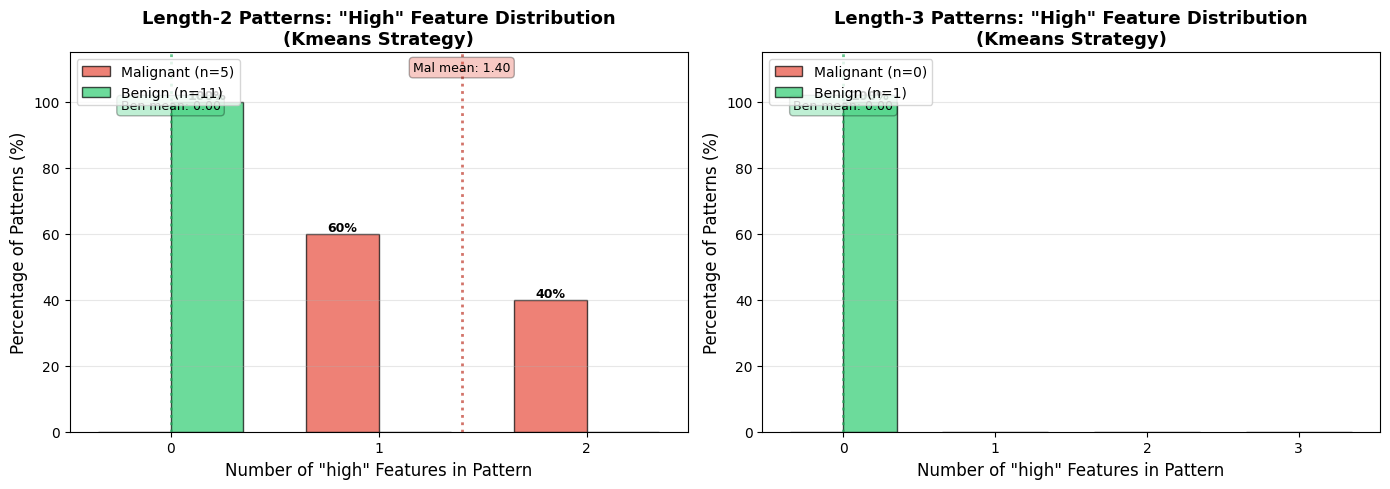

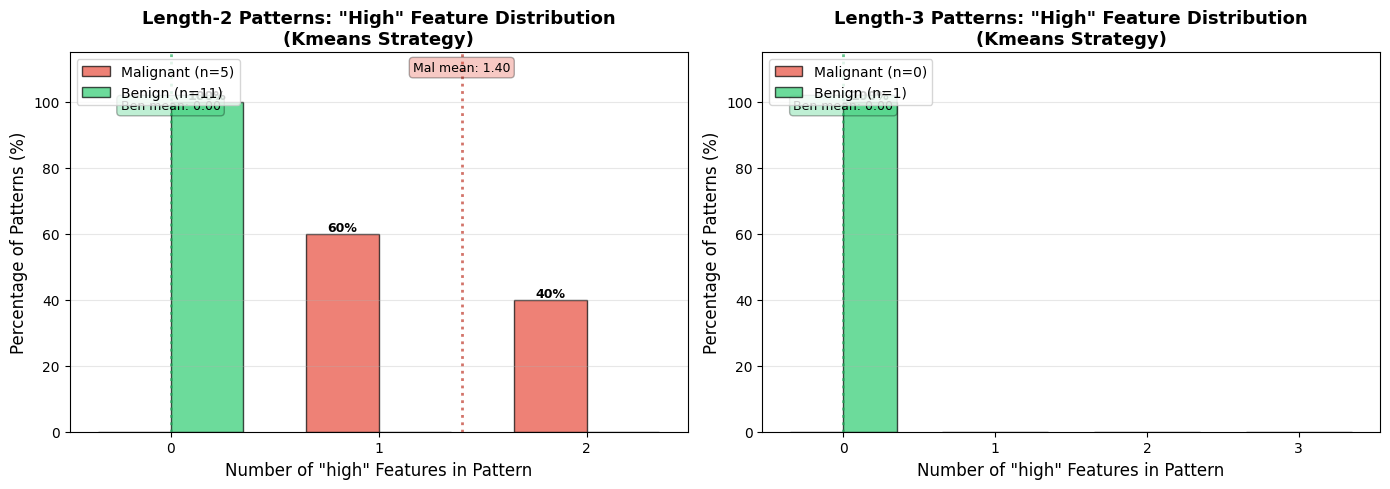

In [ ]:
# Create visualization
analyzer.visualize_high_feature_distribution(results, strategy='kmeans')